# Comparing pykan vs efficient-kan

This notebook compares the original pykan implementation with efficient-kan on a simple sinusoidal function fitting task to verify their equivalence.

In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Import both implementations
from kan import KAN as PyKAN
from efficient_kan import KAN as EfficientKAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility 
torch.manual_seed(42)

Using device: cpu


## Define test function and generate data

In [2]:
def generate_data(n_samples=1000):
    # Generate input data
    x = torch.rand(n_samples, 2, device=device) * 4 - 2  # Range [-2, 2]
    
    # Target function: sin(x1) + cos(x2)
    y = torch.sin(np.pi * x[:,[0]]) + torch.cos(np.pi * x[:,[1]])
    
    # Split into train/test
    train_idx = torch.randperm(n_samples)[:int(0.8*n_samples)]
    test_idx = torch.tensor(list(set(range(n_samples)) - set(train_idx.tolist())))
    
    return {
        'train_input': x[train_idx],
        'train_label': y[train_idx],
        'test_input': x[test_idx],
        'test_label': y[test_idx]
    }

dataset = generate_data(1000)

## Train both models with same architecture

In [3]:
def train_pykan(dataset, grid_size):
    model = PyKAN(width=[2,5,1], grid=grid_size, k=3, device=device)
    results = model.fit(dataset, opt="LBFGS", steps=50)
    return model, results['train_loss'][-1], results['test_loss'][-1]

def train_efficient_kan(dataset, grid_size):
    model = EfficientKAN([2,5,1], grid_size=grid_size, spline_order=3)
    model = model.to(device)
    optimizer = torch.optim.LBFGS(model.parameters(), lr=1)
    
    train_losses = []
    test_losses = []
    
    for i in tqdm(range(50)):
        def closure():
            optimizer.zero_grad()
            y_pred = model(dataset['train_input'])
            loss = nn.functional.mse_loss(y_pred, dataset['train_label'])
            loss.backward()
            return loss
        
        optimizer.step(closure)
        
        with torch.no_grad():
            train_loss = nn.functional.mse_loss(
                model(dataset['train_input']), 
                dataset['train_label']
            )
            test_loss = nn.functional.mse_loss(
                model(dataset['test_input']), 
                dataset['test_label']
            )
            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            
    return model, train_losses[-1], test_losses[-1]

## Compare performance across different grid sizes

In [4]:
grid_sizes = [3, 5, 10, 20, 50]
pykan_train_losses = []
pykan_test_losses = []
effkan_train_losses = []
effkan_test_losses = []

for grid in grid_sizes:
    print(f"\nTraining with grid size {grid}")
    
    print("Training PyKAN...")
    _, train_loss, test_loss = train_pykan(dataset, grid)
    pykan_train_losses.append(train_loss)
    pykan_test_losses.append(test_loss)
    
    print("\nTraining EfficientKAN...")
    _, train_loss, test_loss = train_efficient_kan(dataset, grid)
    effkan_train_losses.append(train_loss)
    effkan_test_losses.append(test_loss)


Training with grid size 3
Training PyKAN...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.67e-02 | test_loss: 2.81e-02 | reg: 1.42e+01 | : 100%|█| 50/50 [00:03<00:00, 12.88it


saving model version 0.1

Training EfficientKAN...


100%|██████████| 50/50 [00:01<00:00, 25.81it/s]



Training with grid size 5
Training PyKAN...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.71e-03 | test_loss: 7.26e-03 | reg: 1.53e+01 | : 100%|█| 50/50 [00:03<00:00, 13.73it


saving model version 0.1

Training EfficientKAN...


100%|██████████| 50/50 [00:02<00:00, 20.10it/s]



Training with grid size 10
Training PyKAN...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.97e-03 | test_loss: 3.56e-03 | reg: 1.50e+01 | : 100%|█| 50/50 [00:03<00:00, 13.26it


saving model version 0.1

Training EfficientKAN...


100%|██████████| 50/50 [00:02<00:00, 18.87it/s]



Training with grid size 20
Training PyKAN...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.07e-02 | test_loss: 2.08e-02 | reg: 1.94e+01 | : 100%|█| 50/50 [00:03<00:00, 14.31it


saving model version 0.1

Training EfficientKAN...


100%|██████████| 50/50 [00:02<00:00, 20.66it/s]



Training with grid size 50
Training PyKAN...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.51e-03 | test_loss: 5.37e-02 | reg: 1.38e+01 | : 100%|█| 50/50 [00:04<00:00, 10.44it


saving model version 0.1

Training EfficientKAN...


100%|██████████| 50/50 [00:03<00:00, 13.04it/s]


## Plot comparison

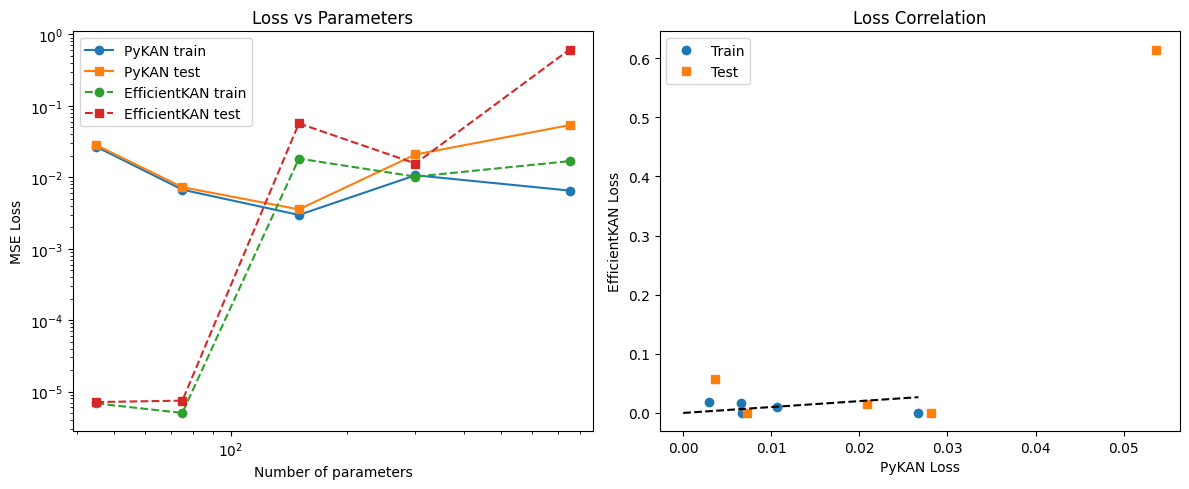

In [5]:
n_params = np.array(grid_sizes) * (2*5 + 5*1)

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(n_params, pykan_train_losses, 'o-', label='PyKAN train')
plt.plot(n_params, pykan_test_losses, 's-', label='PyKAN test')
plt.plot(n_params, effkan_train_losses, 'o--', label='EfficientKAN train')
plt.plot(n_params, effkan_test_losses, 's--', label='EfficientKAN test')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of parameters')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Loss vs Parameters')

plt.subplot(122)
plt.plot(pykan_train_losses, effkan_train_losses, 'o', label='Train')
plt.plot(pykan_test_losses, effkan_test_losses, 's', label='Test')
plt.plot([0, max(pykan_train_losses)], [0, max(pykan_train_losses)], 'k--')
plt.xlabel('PyKAN Loss')
plt.ylabel('EfficientKAN Loss')
plt.legend()
plt.title('Loss Correlation')

plt.tight_layout()
plt.show()

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.97e-03 | test_loss: 3.56e-03 | reg: 1.50e+01 | : 100%|█| 50/50 [00:04<00:00, 11.63it


saving model version 0.1


100%|██████████| 50/50 [00:02<00:00, 17.64it/s]


NameError: name 'pykan_mse' is not defined

<Figure size 1200x600 with 0 Axes>

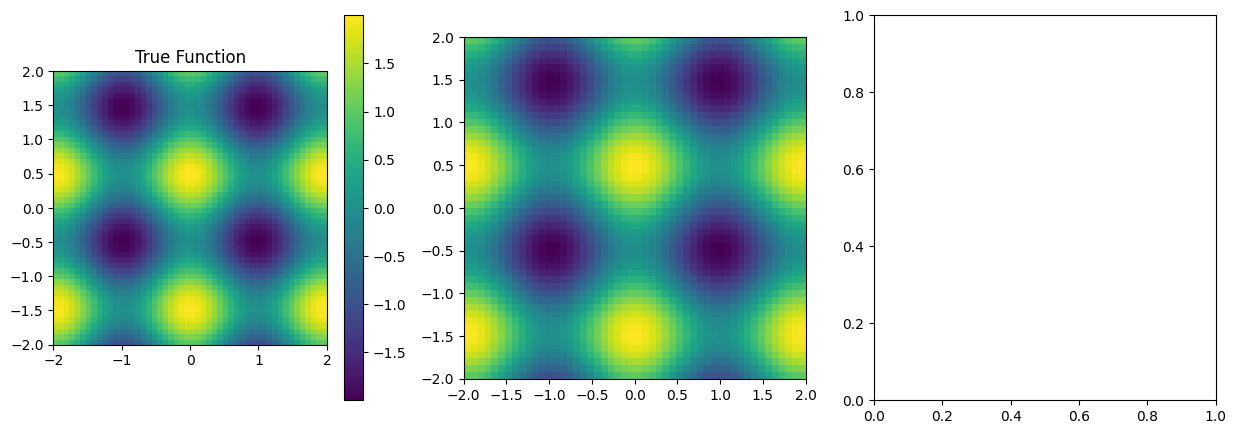

In [6]:
# Create visualization comparing predictions
plt.figure(figsize=(12, 6))

# Select a grid size for detailed comparison (e.g. 10 which showed good performance)
grid_size = 10

# Train models again for visualization
pykan_model, _, _ = train_pykan(dataset, grid_size)
effkan_model, _, _ = train_efficient_kan(dataset, grid_size)

# Create a better visualization comparing predictions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Generate a fine grid of points
x1 = torch.linspace(-2, 2, 50)
x2 = torch.linspace(-2, 2, 50)
X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
test_inputs = torch.stack([X1.flatten(), X2.flatten()], dim=1)

# Get predictions
with torch.no_grad():
    pykan_preds = pykan_model(test_inputs).reshape(50, 50)
    effkan_preds = effkan_model(test_inputs).reshape(50, 50)
    true_vals = (torch.sin(np.pi * test_inputs[:,[0]]) + 
                 torch.cos(np.pi * test_inputs[:,[1]])).reshape(50, 50)

# Plot true function
im0 = axes[0].imshow(true_vals.numpy(), extent=[-2, 2, -2, 2], origin='lower')
axes[0].set_title('True Function')
plt.colorbar(im0, ax=axes[0])

# Plot PyKAN predictions
im1 = axes[1].imshow(pykan_preds.numpy(), extent=[-2, 2, -2, 2], origin='lower')
axes[1].set_title(f'PyKAN Predictions\nMSE: {pykan_mse:.4f}')
plt.colorbar(im1, ax=axes[1])

# Plot EfficientKAN predictions
im2 = axes[2].imshow(effkan_preds.numpy(), extent=[-2, 2, -2, 2], origin='lower')
axes[2].set_title(f'EfficientKAN Predictions\nMSE: {effkan_mse:.4f}')
plt.colorbar(im2, ax=axes[2])

# Add labels and grid to all subplots
for ax in axes:
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Generate 1D data
def generate_1d_data(n_samples=1000):
    # Generate input data
    x = torch.linspace(-2, 2, n_samples).reshape(-1, 1)
    
    # Target function: sin(x)
    y = torch.sin(np.pi * x)
    
    # Split into train/test
    train_idx = torch.randperm(n_samples)[:int(0.8*n_samples)]
    test_idx = torch.tensor(list(set(range(n_samples)) - set(train_idx.tolist())))
    
    return {
        'train_input': x[train_idx],
        'train_label': y[train_idx],
        'test_input': x[test_idx],
        'test_label': y[test_idx]
    }

def train_pykan(dataset, grid_size):
    # Changed width from [2,5,1] to [1,5,1] for 1D input
    model = PyKAN(width=[1,5,1], grid=grid_size, k=3, device=device)
    results = model.fit(dataset, opt="LBFGS", steps=50)
    return model, results['train_loss'][-1], results['test_loss'][-1]

def train_efficient_kan(dataset, grid_size):
    # Changed input dimensions from [2,5,1] to [1,5,1] for 1D input
    model = EfficientKAN([1,5,1], grid_size=grid_size, spline_order=3)
    model = model.to(device)
    optimizer = torch.optim.LBFGS(model.parameters(), lr=1)
    
    train_losses = []
    test_losses = []
    
    for i in tqdm(range(50)):
        def closure():
            optimizer.zero_grad()
            y_pred = model(dataset['train_input'])
            loss = nn.functional.mse_loss(y_pred, dataset['train_label'])
            loss.backward()
            return loss
        
        optimizer.step(closure)
        
        with torch.no_grad():
            train_loss = nn.functional.mse_loss(
                model(dataset['train_input']), 
                dataset['train_label']
            )
            test_loss = nn.functional.mse_loss(
                model(dataset['test_input']), 
                dataset['test_label']
            )
            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            
    return model, train_losses[-1], test_losses[-1]

# Generate dataset and proceed with rest of the code as before
dataset = generate_1d_data(1000)

# Train both models
grid_size = 10
pykan_model, pykan_train_loss, pykan_test_loss = train_pykan(dataset, grid_size)
effkan_model, effkan_train_loss, effkan_test_loss = train_efficient_kan(dataset, grid_size)

# Generate fine grid for smooth visualization
x_fine = torch.linspace(-2, 2, 200).reshape(-1, 1)

# Get predictions
with torch.no_grad():
    pykan_preds = pykan_model(x_fine)
    effkan_preds = effkan_model(x_fine)
    true_vals = torch.sin(np.pi * x_fine)

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and test data
plt.scatter(dataset['train_input'], dataset['train_label'], 
           color='gray', alpha=0.5, label='Training Data')
plt.scatter(dataset['test_input'], dataset['test_label'], 
           color='black', alpha=0.5, label='Test Data')

# Plot predictions
plt.plot(x_fine, true_vals, 'k-', label='True Function', linewidth=2)
plt.plot(x_fine, pykan_preds, 'b-', 
        label=f'PyKAN [Test MSE: {pykan_test_loss:.4f}]', linewidth=2)
plt.plot(x_fine, effkan_preds, 'r-', 
        label=f'EfficientKAN [Test MSE: {effkan_test_loss:.4f}]', linewidth=2)

plt.title('1D Sine Function Predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pykan_model.plot()

In [ ]:
# First make the model symbolic
pykan_model.auto_symbolic()

# Then get and display the symbolic formula 
from kan.utils import ex_round
formula = ex_round(pykan_model.symbolic_formula()[0][0], 4)
formula

In [ ]:
def train_pykan(dataset, grid_size):
    # Changed width from [2,5,1] to [1,5,1] for 1D input
    model = PyKAN(width=[1,5,1], grid=grid_size, k=3, device=device)
    results = model.fit(dataset, opt="LBFGS", steps=50)
    return model, results['train_loss'][-1], results['test_loss'][-1]

def train_efficient_kan(dataset, grid_size):
    # Changed input dimensions from [2,5,1] to [1,5,1] for 1D input
    model = EfficientKAN([1,5,1], grid_size=grid_size, spline_order=3)
    model = model.to(device)
    optimizer = torch.optim.LBFGS(model.parameters(), lr=1)
    
    train_losses = []
    test_losses = []
    
    for i in tqdm(range(50)):
        def closure():
            optimizer.zero_grad()
            y_pred = model(dataset['train_input'])
            loss = nn.functional.mse_loss(y_pred, dataset['train_label'])
            loss.backward()
            return loss
        
        optimizer.step(closure)
        
        with torch.no_grad():
            train_loss = nn.functional.mse_loss(
                model(dataset['train_input']), 
                dataset['train_label']
            )
            test_loss = nn.functional.mse_loss(
                model(dataset['test_input']), 
                dataset['test_label']
            )
            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            
    return model, train_losses[-1], test_losses[-1]

# Generate 1D data with train/test split by domain
def generate_1d_data(n_train=800, n_test=200):
    # Training data from [-2, 1]
    x_train = torch.linspace(-2, 1, n_train).reshape(-1, 1)
    y_train = torch.sin(np.pi * x_train)
    
    # Test data from [1, 2]
    x_test = torch.linspace(1, 2, n_test).reshape(-1, 1)
    y_test = torch.sin(np.pi * x_test)
    
    return {
        'train_input': x_train,
        'train_label': y_train,
        'test_input': x_test,
        'test_label': y_test
    }

# Rest of the training code remains the same...
dataset = generate_1d_data(800, 200)

# Train both models
grid_size = 10
pykan_model, pykan_train_loss, pykan_test_loss = train_pykan(dataset, grid_size)
effkan_model, effkan_train_loss, effkan_test_loss = train_efficient_kan(dataset, grid_size)

# Generate fine grid for smooth visualization
x_fine = torch.linspace(-2, 2, 200).reshape(-1, 1)

# Get predictions
with torch.no_grad():
    pykan_preds = pykan_model(x_fine)
    effkan_preds = effkan_model(x_fine)
    true_vals = torch.sin(np.pi * x_fine)

# Plotting
plt.figure(figsize=(12, 6))

# Plot data with clear train/test split
plt.scatter(dataset['train_input'], dataset['train_label'], 
           color='gray', alpha=0.5, label='Training Data')
plt.scatter(dataset['test_input'], dataset['test_label'], 
           color='black', alpha=0.5, label='Test Data')

# Add vertical line to show train/test split
plt.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)

# Plot predictions
plt.plot(x_fine, true_vals, 'k-', label='True Function', linewidth=2)
plt.plot(x_fine, pykan_preds, 'b-', 
        label=f'PyKAN [Test MSE: {pykan_test_loss:.4f}]', linewidth=2)
plt.plot(x_fine, effkan_preds, 'r-', 
        label=f'EfficientKAN [Test MSE: {effkan_test_loss:.4f}]', linewidth=2)

plt.title('1D Sine Function Predictions (Extrapolation Test)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pykan_model.plot()

In [ ]:
# First make the model symbolic
pykan_model.auto_symbolic()

# Then get and display the symbolic formula 
from kan.utils import ex_round
formula = ex_round(pykan_model.symbolic_formula()[0][0], 4)
formula